In [ ]:
!pip install Pillow
!pip install numpy
!pip install tensorflow
!pip install keras
!pip install pandas

In [ ]:
from PIL import Image
import numpy as np
import pandas as pd
from google.colab import drive
import os

# Google Drive 마운트
drive.mount('/content/drive')

# 프로젝트 디렉토리 경로 설정 train 이미지, test 이미지
data_image = '/content/drive/MyDrive/AI_SWU_PROJECT/trainN/image'


#label 로드
train_labels = pd.read_csv("/content/drive/MyDrive/AI_SWU_PROJECT/trainLabels.csv")
labels=train_labels['Class'].values

print("완료")


Mounted at /content/drive
완료


## 데이터 전처리

In [ ]:
# 프로젝트 디렉토리 경로 설정
project_directory = '/content/drive/MyDrive/AI_SWU_PROJECT'

# 변환된 이미지를 저장할 디렉토리 설정
output_directory = os.path.join(project_directory, 'processed_images')
os.makedirs(output_directory, exist_ok=True)

# Test와 Train 디렉토리 설정
malware_directory_test = os.path.join(project_directory, 'test/bytes_files')
malware_directory_train = os.path.join(project_directory, 'train/bytes_files')

### bytes에서 png 변환

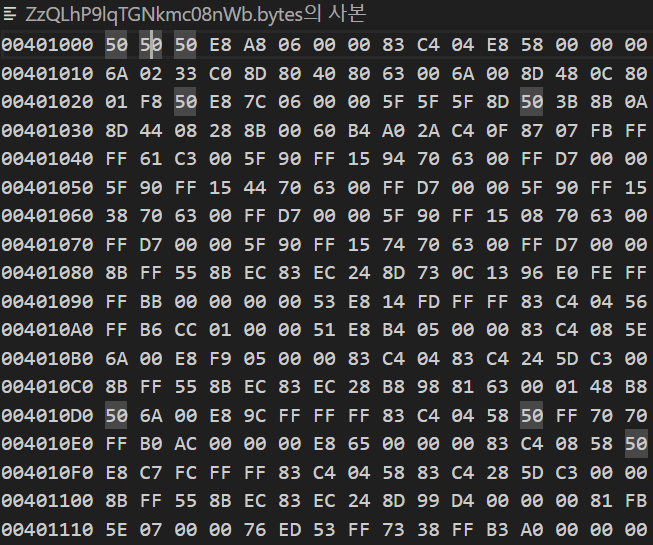

In [ ]:
# 데이터 변환 함수
def convert_and_save(array, output_path, name):
    print(f'Processing {name}')

    # 이미지 크기 계산: 가장 가까운 2의 거듭제곱
    b = int((array.shape[0] * 16) ** 0.5)
    b = 2 ** (int(log(b) / log(2)) + 1)  # 가장 가까운 2의 거듭제곱
    a = int(array.shape[0] * 16 / b)

    # 데이터 크기 조정
    array = array[:a * b // 16, :]  # 필요한 부분만 사용
    array = np.reshape(array, (a, b))  # (a, b) 크기로 재구성

    # 배열을 이미지로 변환
    im = Image.fromarray(np.uint8(array))
    im.save(output_path, "PNG")  # PNG로 저장
    return im

# 디렉토리 내 모든 .bytes 파일을 PNG로 변환
def process_bytes_files(input_directory, output_directory):
    for filename in os.listdir(input_directory):
        if filename.endswith(".bytes"):  # .bytes 파일만 처리
            input_path = os.path.join(input_directory, filename)
            output_path = os.path.join(output_directory, f"{os.path.splitext(filename)[0]}.png")

            with open(input_path, 'r') as file:
                data = file.readlines()

            array = []
            for line in data:
                tokens = line.split()[1:]  # 첫 번째 주소 부분 제외
                if len(tokens) != 16:  # 데이터가 16개 열이 아니면 무시
                    continue
                # 16진수 -> 정수 변환 ('??'는 0으로 처리)
                row = [int(token, 16) if token != '??' else 0 for token in tokens]
                array.append(row)

            # NumPy 배열로 변환
            array = np.array(array, dtype=np.uint8)

            # `convert_and_save` 함수로 변환 및 저장
            convert_and_save(array, output_path, filename)

In [ ]:
# 데이터 처리
train_output_directory = os.path.join(output_directory, "train")
os.makedirs(train_output_directory, exist_ok=True)
process_bytes_files(malware_directory_train, train_output_directory)

print("PNG 이미지 변환 완료. 변환된 이미지는 'processed_images' 디렉토리에 저장되었습니다.")

### trainLabels 로드

Class
3    2942
2    2478
1    1541
8    1228
9    1013
6     751
4     475
7     398
5      42
Name: count, dtype: int64


<ipython-input-2-aff9c376caea>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


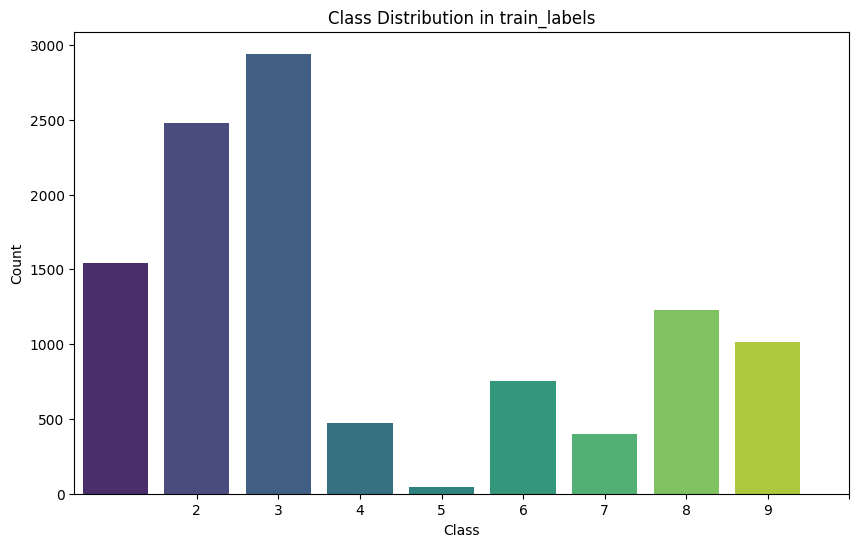

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train_labels = pd.read_csv("/content/drive/MyDrive/AI_SWU_PROJECT/trainLabels.csv")

# train_labels에서 'Class' 컬럼에 대한 클래스별 개수 계산
class_counts = train_labels['Class'].value_counts()

# 클래스별 개수 출력
print(class_counts)

# 그래프 출력
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')

plt.title('Class Distribution in train_labels')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(class_counts.index)  # x축 레이블 설정
plt.show()

### 데이터 클래스별 분리

In [ ]:
import pandas as pd
import os
import shutil

# 1. trainLabels.csv 로드
train_labels_path = "/content/drive/MyDrive/AI_SWU_PROJECT/trainLabels.csv"
labels_df = pd.read_csv(train_labels_path)
print("trainLabels.csv 로드 완료.")

# 라벨링 정보를 딕셔너리로 변환
labels_dict = dict(zip(labels_df['Id'], labels_df['Class']))
print(f"총 라벨 개수: {len(labels_dict)}")

# 원본 이미지 디렉토리와 출력 디렉토리 설정
original_images_dir = '/content/drive/MyDrive/AI_SWU_PROJECT/processed_images/dl_image'  # 원본 이미지 디렉토리
output_dir = '/content/drive/MyDrive/AI_SWU_PROJECT/data_image'  # 클래스별 폴더가 저장될 디렉토리
os.makedirs(output_dir, exist_ok=True)

# 레이블을 기준으로 이미지 분배
missing_files = []
for index, row in labels_df.iterrows():
    image_name = row['Id'] + '.png'  # 이미지 파일 이름
    label = row['Class']  # 레이블 (클래스)

    # 클래스별 폴더 생성
    class_folder = os.path.join(output_dir, str(label))
    os.makedirs(class_folder, exist_ok=True)

    # 원본 이미지 경로
    original_image_path = os.path.join(original_images_dir, image_name)

    # 클래스별 폴더로 이미지 이동
    if os.path.exists(original_image_path):
        shutil.copy(original_image_path, os.path.join(class_folder, image_name))  # 복사
    else:
        missing_files.append(image_name)  # 누락된 파일 기록

    # 진행 상황 로그
    if index % 100 == 0:
        print(f"{index}/{len(labels_df)} 파일 처리 완료.")

# 누락된 파일 출력
if missing_files:
    print(f"\n{len(missing_files)}개의 파일이 누락되었습니다:")
    print(missing_files)
else:
    print("\n모든 파일이 정상적으로 처리되었습니다.")

print("이미지 이동 완료. 클래스별 폴더가 생성되었습니다.")


trainLabels.csv 로드 완료.
총 라벨 개수: 10868
0/10868 파일 처리 완료.
100/10868 파일 처리 완료.


KeyboardInterrupt: 

### 데이터클래스별총개수확인

In [ ]:
import os

# 디렉토리 경로 설정
base_dir = "/content/drive/MyDrive/AI_SWU_PROJECT/data_image"

# 폴더별 파일 개수를 세는 함수
def count_files_in_folders(base_dir):
    folder_file_counts = {}
    total_files = 0

    # 각 폴더 탐색
    for folder_name in sorted(os.listdir(base_dir)):
        folder_path = os.path.join(base_dir, folder_name)
        if os.path.isdir(folder_path):  # 디렉토리인지 확인
            # 폴더 안의 파일 개수 세기
            file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
            folder_file_counts[folder_name] = file_count
            total_files += file_count

    return folder_file_counts, total_files

# 파일 개수 확인
folder_file_counts, total_files = count_files_in_folders(base_dir)

# 폴더별 파일 개수 출력
for folder, count in folder_file_counts.items():
    print(f"Folder {folder}: {count} files")

# 전체 파일 개수 출력
print(f"\nTotal files in all folders: {total_files}")

Folder 1: 1541 files
Folder 2: 2478 files
Folder 3: 2942 files
Folder 4: 475 files
Folder 5: 42 files
Folder 6: 751 files
Folder 7: 398 files
Folder 8: 1228 files
Folder 9: 1013 files

Total files in all folders: 10868


In [ ]:
# 데이터 손실 여부 확인
from PIL import Image
import os


# 디렉토리 경로 설정
base_dir = "/content/drive/MyDrive/AI_SWU_PROJECT/data_image"

for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            try:
                with Image.open(file_path) as img:
                    print(f"Valid image: {file_path}, Size: {img.size}")
            except Exception as e:
                print(f"Invalid image: {file_path}, Error: {e}")

Streaming output truncated to the last 5000 lines.
Valid image: /content/drive/MyDrive/AI_SWU_PROJECT/data_image/3/E1lymL5AhVWeUwCtv68I.png, Size: (2048, 1144)
Valid image: /content/drive/MyDrive/AI_SWU_PROJECT/data_image/3/e1oUMvCJ5rNWFnLdPglK.png, Size: (2048, 1526)
Valid image: /content/drive/MyDrive/AI_SWU_PROJECT/data_image/3/E1rBMI2bn3vDA0OVR65f.png, Size: (2048, 1144)
Valid image: /content/drive/MyDrive/AI_SWU_PROJECT/data_image/3/E2C6RYXoIvAVKsBNfiOP.png, Size: (2048, 1526)
Valid image: /content/drive/MyDrive/AI_SWU_PROJECT/data_image/3/e265VErTdZzJDUS4xA7i.png, Size: (2048, 1144)
Valid image: /content/drive/MyDrive/AI_SWU_PROJECT/data_image/3/e2taZQLKCScNzTV7d0oh.png, Size: (2048, 1146)
Valid image: /content/drive/MyDrive/AI_SWU_PROJECT/data_image/3/E3BIVijdM2ck7KGTzfyY.png, Size: (2048, 1144)
Valid image: /content/drive/MyDrive/AI_SWU_PROJECT/data_image/3/e3HSBfTA9MXzhEN2qIpL.png, Size: (2048, 1144)
Valid image: /content/drive/MyDrive/AI_SWU_PROJECT/data_image/3/e3oFfwX7HCTlg

ImageDataGenerator통한이미지로드

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    directory=base_dir,
    target_size=(64, 64),
    color_mode='grayscale',
    batch_size=10868
)

Found 10868 images belonging to 9 classes.


In [ ]:
# train_generator에서 이미지와 라벨 가져오기
imgs, labels = next(train_generator)

# 이미지의 크기와 라벨 확인
print(f"Images shape: {imgs.shape}")
print(f"Labels shape: {labels.shape}")

Images shape: (10868, 64, 64, 1)
Labels shape: (10868, 9)


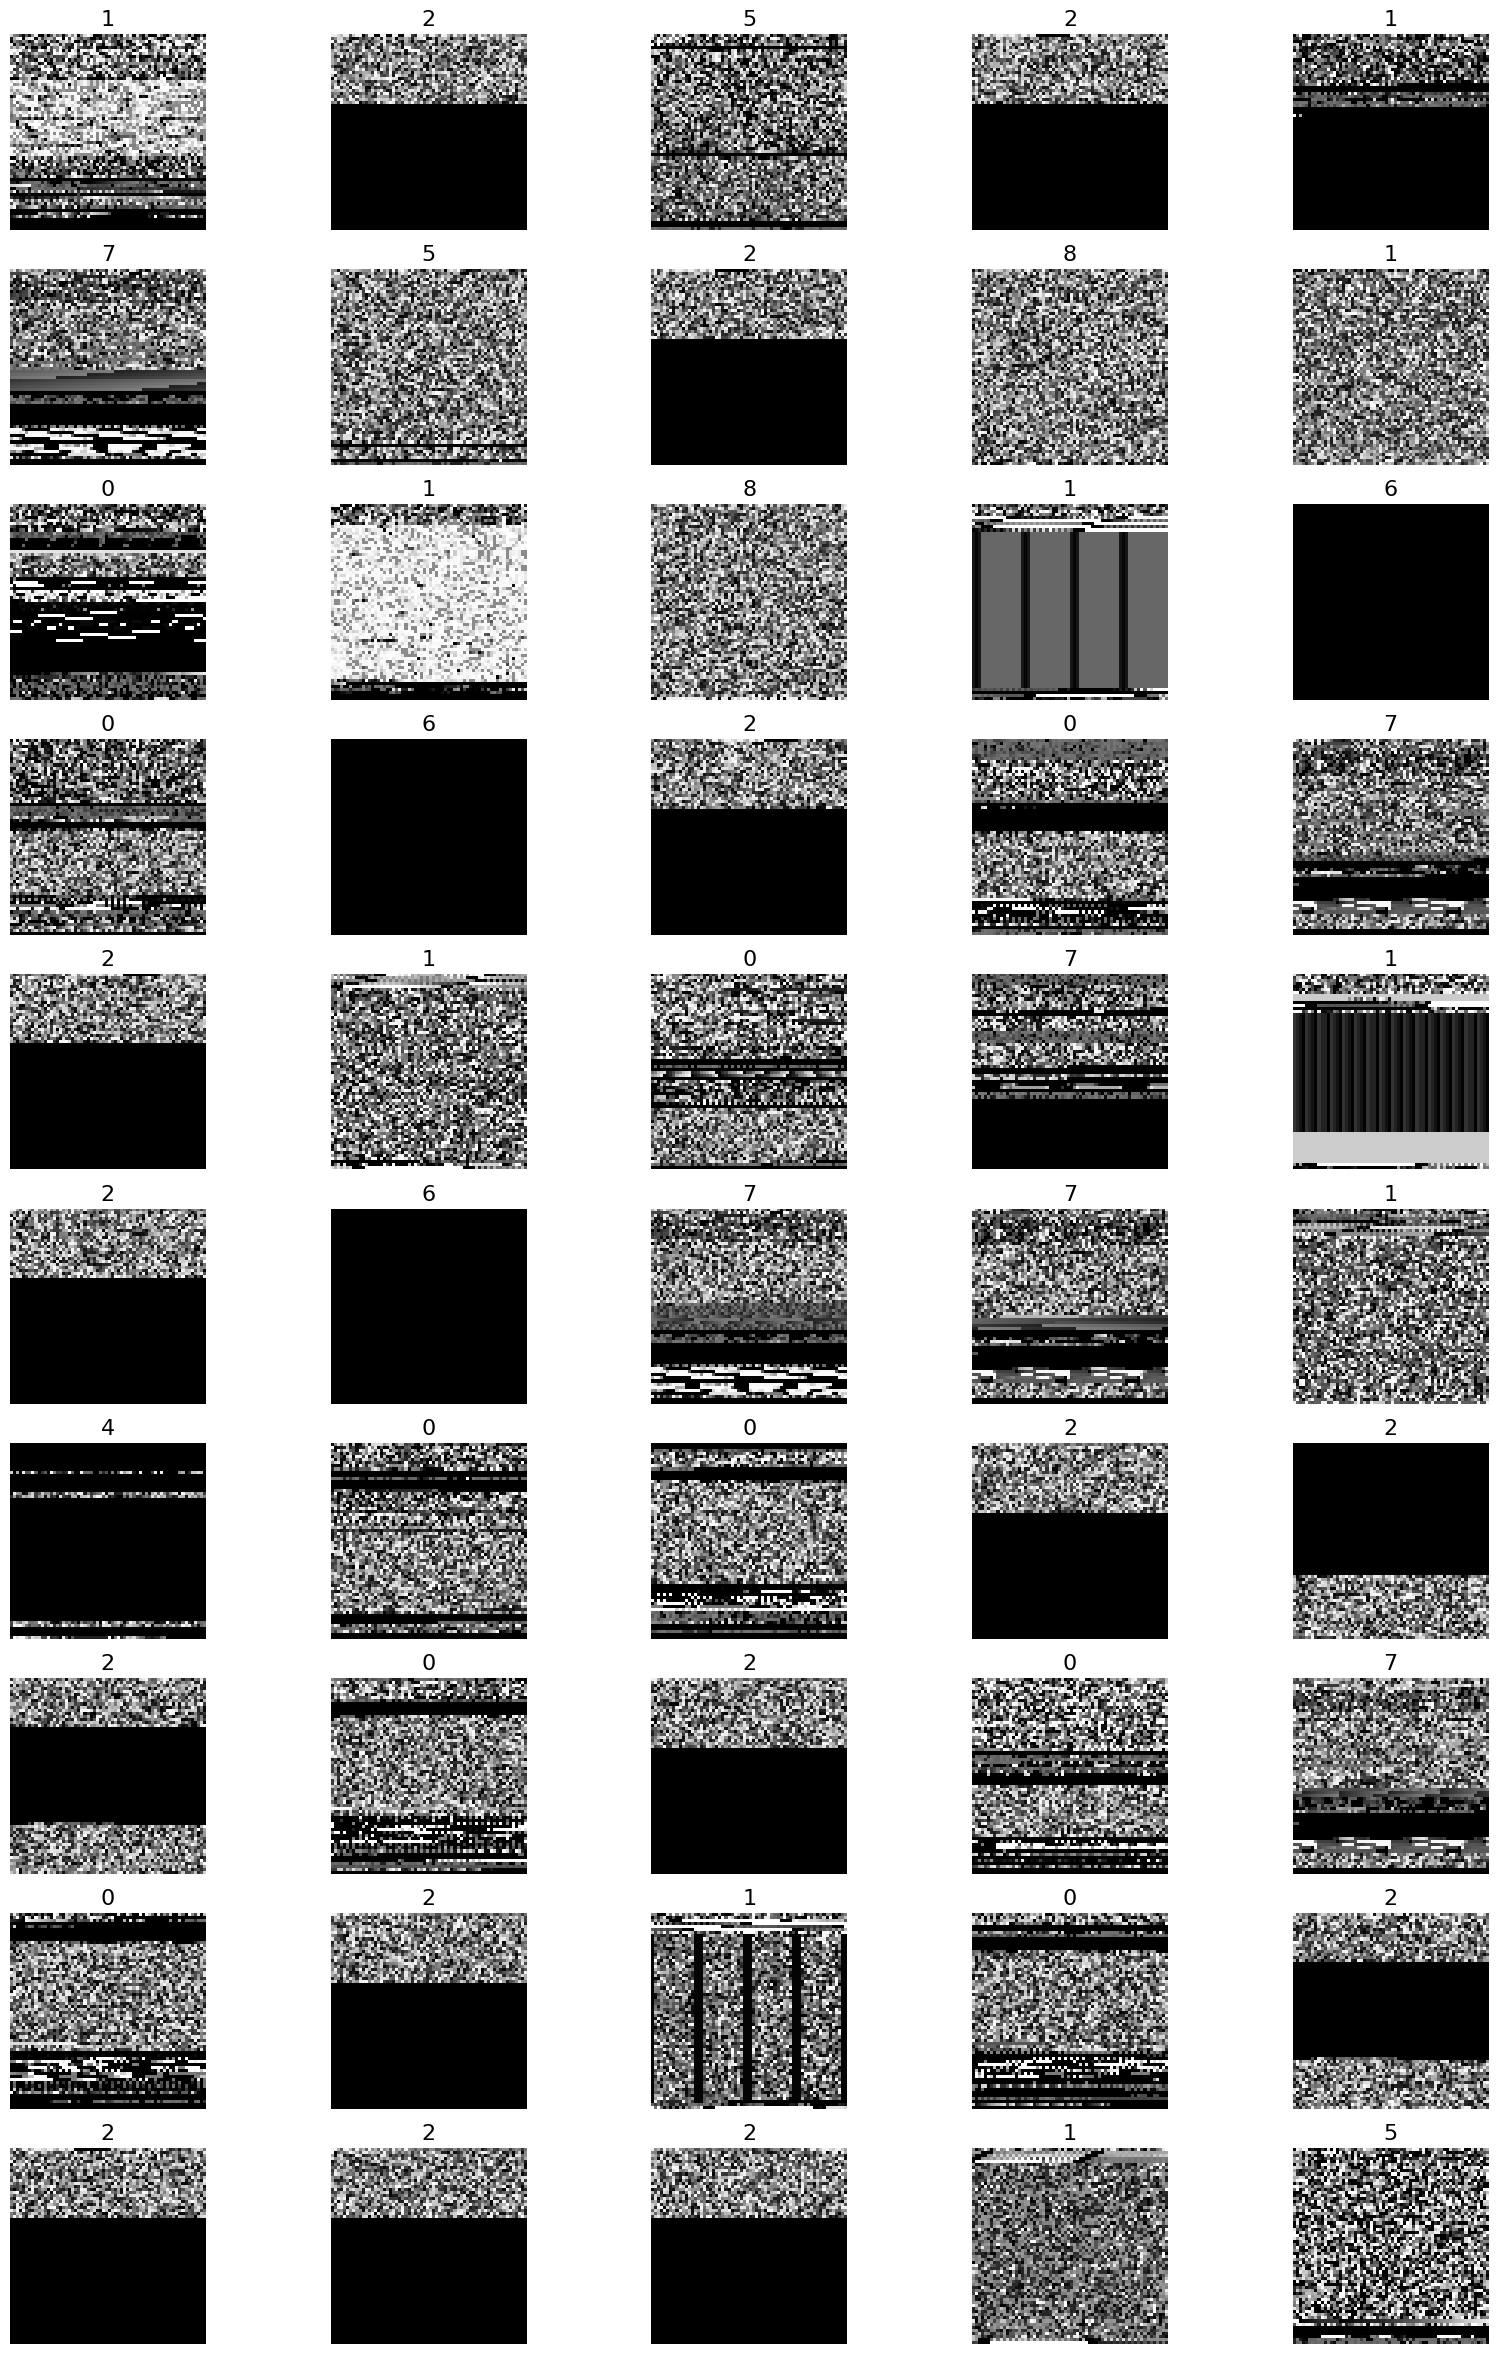

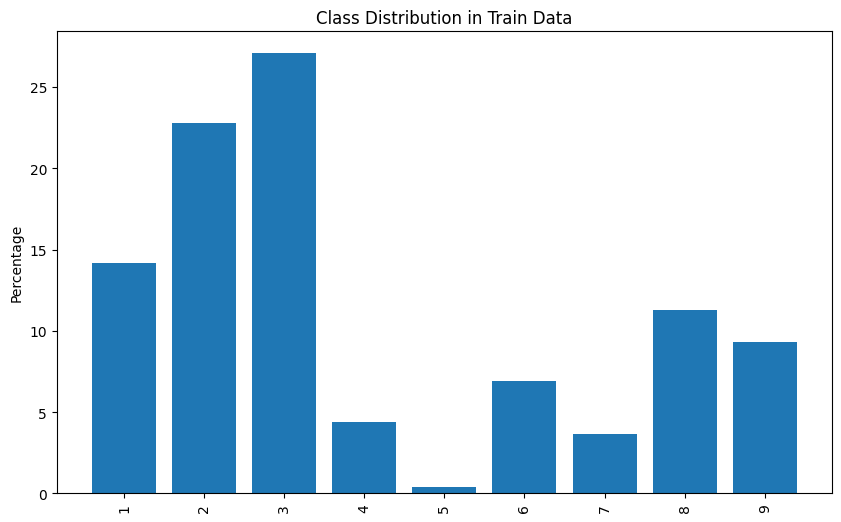

In [ ]:
# 시각화 함수 정의
import matplotlib.pyplot as plt
import numpy as np

# 이미지와 라벨을 시각화하는 함수
def plots(ims, figsize=(20, 30), rows=10, interp=False, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims) // rows if len(ims) % rows == 0 else len(ims) // rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i + 1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        # 채널이 1개라면 squeeze로 2D로 변환
        plt.imshow(ims[i].squeeze(), cmap='gray', interpolation=None if interp else 'none')

# 시각화: 첫 50개의 이미지와 라벨
plots(imgs[:50], titles=np.argmax(labels[:50], axis=1))

# 클래스 분포 확인
classes = list(train_generator.class_indices.keys())
class_counts = np.sum(labels, axis=0)
class_percentages = (class_counts / labels.shape[0]) * 100

# 클래스 분포 시각화
plt.figure(figsize=(10, 6))
plt.bar(classes, class_percentages)
plt.xticks(rotation=90)
plt.ylabel("Percentage")
plt.title("Class Distribution in Train Data")
plt.show()

### train/test/val데이터분리

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(imgs/255., labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# # from sklearn.model_selection import train_test_split
# # X_train, X_test, y_train, y_test = train_test_split(imgs/255.,labels, test_size=0.3)

X_train.shape

(7607, 64, 64, 1)

In [ ]:
X_test.shape

(1631, 64, 64, 1)

In [ ]:
y_train.shape

(7607, 9)

In [ ]:
y_test.shape

(1631, 9)

In [ ]:
X_val.shape

(1630, 64, 64, 1)

In [ ]:
y_val.shape

(1630, 9)

## CNN모델설계

In [ ]:
# 딥러닝 모델 정의 함수
def malware_model():
    Malware_model = Sequential()  # Sequential 모델 생성

    # 첫 번째 합성곱 층
    Malware_model.add(Conv2D(30, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 1)))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))

    # 두 번째 합성곱 층
    Malware_model.add(Conv2D(64, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))

    # 드롭아웃 층 : 과적합 방지를 위해 25%의 뉴런을 무작위로 비활성화
    Malware_model.add(Dropout(0.25))

    # Flatten 층 : 다차원 출력을 1차원으로 변환
    Malware_model.add(Flatten())

    # Fully Connected 층
    Malware_model.add(Dense(64, activation='relu'))
    Malware_model.add(Dropout(0.5))

    # 출력층 : num_classes 개의 뉴런, softmax 활성화 (다중 클래스 분류)
    Malware_model.add(Dense(num_classes, activation='softmax'))

    # 모델 컴파일: 손실 함수, 최적화 알고리즘, 평가 지표 설정
    Malware_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return Malware_model

# Recall 지표 계산 함수
def recall_m(y_test, y_pred):
    true_positives = K.sum(K.round(K.clip(y_test * y_pred, 0, 1)))  # 실제 양성 예측 수
    possible_positives = K.sum(K.round(K.clip(y_test, 0, 1)))  # 실제 양성 수
    recall = true_positives / (possible_positives + K.epsilon())  # Recall 계산
    return recall

# Precision 지표 계산 함수
def precision_m(y_test, y_pred):
    true_positives = K.sum(K.round(K.clip(y_test * y_pred, 0, 1)))  # 실제 양성 예측 수
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))  # 예측된 양성 수
    precision = true_positives / (predicted_positives + K.epsilon())  # Precision 계산
    return precision

# F1 점수 계산 함수
def f1_m(y_test, y_pred):
    precision = precision_m(y_test, y_pred)  # Precision 계산 호출
    recall = recall_m(y_test, y_pred)  # Recall 계산 호출
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))  # F1 점수 계산

In [ ]:
# 모델 생성
Malware_model = malware_model()

# 모델 요약 출력
Malware_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 62, 62, 30)          │             300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 31, 31, 30)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 29, 29, 64)          │          17,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │         802,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 821,109 (3.13 MB)

 Trainable params: 821,109 (3.13 MB)

 Non-trainable params: 0 (0.00 B)

### 원-핫 인코딩에서 클래스 라벨로 변환

In [ ]:
# y_train을 원-핫 인코딩에서 클래스 라벨로 변환
#클래스 불균형 처리를 위해 class_weight를 계산할 때, 클래스별 샘플 개수가 필요하므로 정수형 클래스 라벨이 더 유용
y_train_new = np.argmax(y_train, axis=1)
y_train_new


array([1, 0, 5, ..., 1, 1, 5])

## 클래스 가중치 적용하여 모델 학습

binary_crossentropy로 변경하여 클래스 간 불균형 문제를 다루고 각 클래스의 독립적인 확률을 기반으로 평가

In [ ]:
from sklearn.utils import class_weight

# 클래스 불균형을 고려한 가중치 계산
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_train_new),
                                                 y = y_train_new)

#class_weights = {i : class_weights[i] for i in range(5)}
# 클래스 가중치를 딕셔너리 형태로 변환
class_weights = {l:c for l,c in zip(np.unique(y_train_new), class_weights)}

# 모델 다시 컴파일: 손실 함수, 최적화 알고리즘, 평가 지표 설정
Malware_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_m,precision_m, recall_m,AUC()])

# 모델 학습: 훈련 데이터와 검증 데이터, 에포크 수, 클래스 가중치 설정
Malware_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25, class_weight=class_weights)

# 모델 평가: 테스트 데이터에서 손실과 성능 측정
scores = Malware_model.evaluate(X_test, y_test)
loss, accuracy, f1_score, precision, recall = Malware_model.evaluate(X_test, y_test)

# 최종 정확도 출력
print('Final CNN accuracy: ', scores[1])

Epoch 1/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - auc_14: 0.5064 - f1_m: 0.0045 - loss: 0.4654 - precision_m: 0.0360 - recall_m: 0.0026 - val_auc_14: 0.5653 - val_f1_m: 0.0000e+00 - val_loss: 0.3498 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - auc_14: 0.4951 - f1_m: 0.0000e+00 - loss: 0.3745 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_auc_14: 0.6247 - val_f1_m: 0.0000e+00 - val_loss: 0.3462 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - auc_14: 0.5328 - f1_m: 6.5686e-04 - loss: 0.3592 - precision_m: 0.0067 - recall_m: 3.4903e-04 - val_auc_14: 0.7638 - val_f1_m: 0.0000e+00 - val_loss: 0.3166 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - auc_14: 0.7500 - f1_m: 0.0612 - loss: 0.3137 - precision_m: 0.3763 - recall_m: 0.0344 - val_auc_14: 0.8774 - val_f1_m: 0.3530 - val_loss: 

Epoch 1/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - accuracy: 0.7068 - auc_10: 0.9541 - f1_m: 0.6891 - loss: 0.1687 - precision_m: 0.8727 - recall_m: 0.5742 - val_accuracy: 0.8006 - val_auc_10: 0.9755 - val_f1_m: 0.7906 - val_loss: 0.1182 - val_precision_m: 0.9330 - val_recall_m: 0.6884
Epoch 2/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.7168 - auc_10: 0.9577 - f1_m: 0.7078 - loss: 0.1725 - precision_m: 0.8578 - recall_m: 0.6056 - val_accuracy: 0.8252 - val_auc_10: 0.9769 - val_f1_m: 0.7995 - val_loss: 0.1106 - val_precision_m: 0.9443 - val_recall_m: 0.6951
Epoch 3/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.7270 - auc_10: 0.9619 - f1_m: 0.7266 - loss: 0.1637 - precision_m: 0.8818 - recall_m: 0.6210 - val_accuracy: 0.8129 - val_auc_10: 0.9770 - val_f1_m: 0.7882 - val_loss: 0.1166 - val_precision_m: 0.9431 - val_recall_m: 0.6791
Epoch 4/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.7198 - auc_10: 0.9602 - f1_m: 0.7134 - loss: 0.1648 - pr

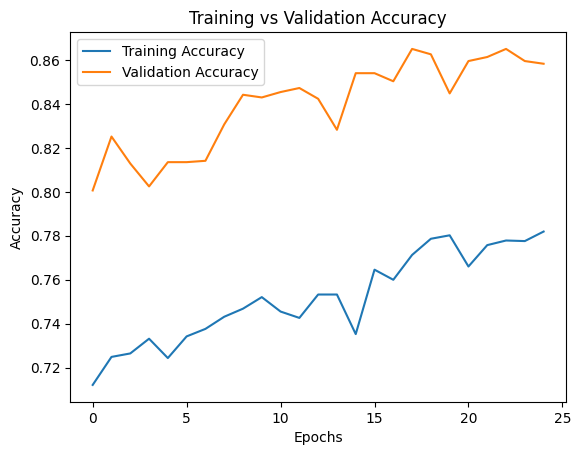

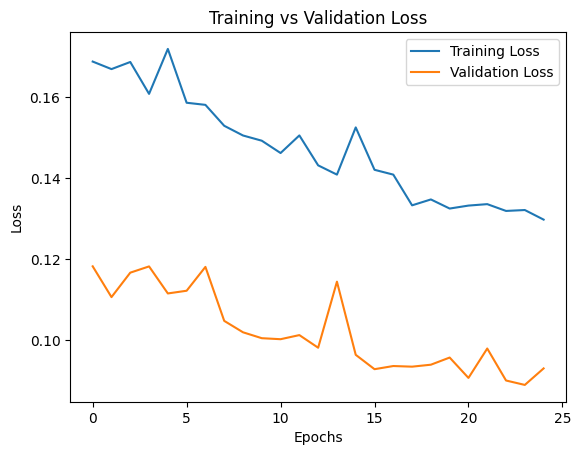

In [ ]:
import matplotlib.pyplot as plt

# 모델 다시 컴파일: 손실 함수, 최적화 알고리즘, 평가 지표 설정
Malware_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_m,precision_m, recall_m,AUC(), 'accuracy'])
# 학습 기록(history)로부터 훈련 및 검증 데이터의 성능 시각화
history = Malware_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25, class_weight=class_weights)

# 정확도 시각화
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

# 손실 시각화
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


### Confusion Matrix : 분류 모델의 성능을 평가

```
                   Predicted: Positive	Predicted: Negative
Actual: Positive	True Positive (TP)	 False Negative (FN)
Actual: Negative	False Positive (FP)	True Negative (TN)
```



51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


,CNN Model,Accuracy,Loss,Precision,Recall,f1 score
0,Malware model,0.729116,0.134279,0.606321,0.969316,0.92226


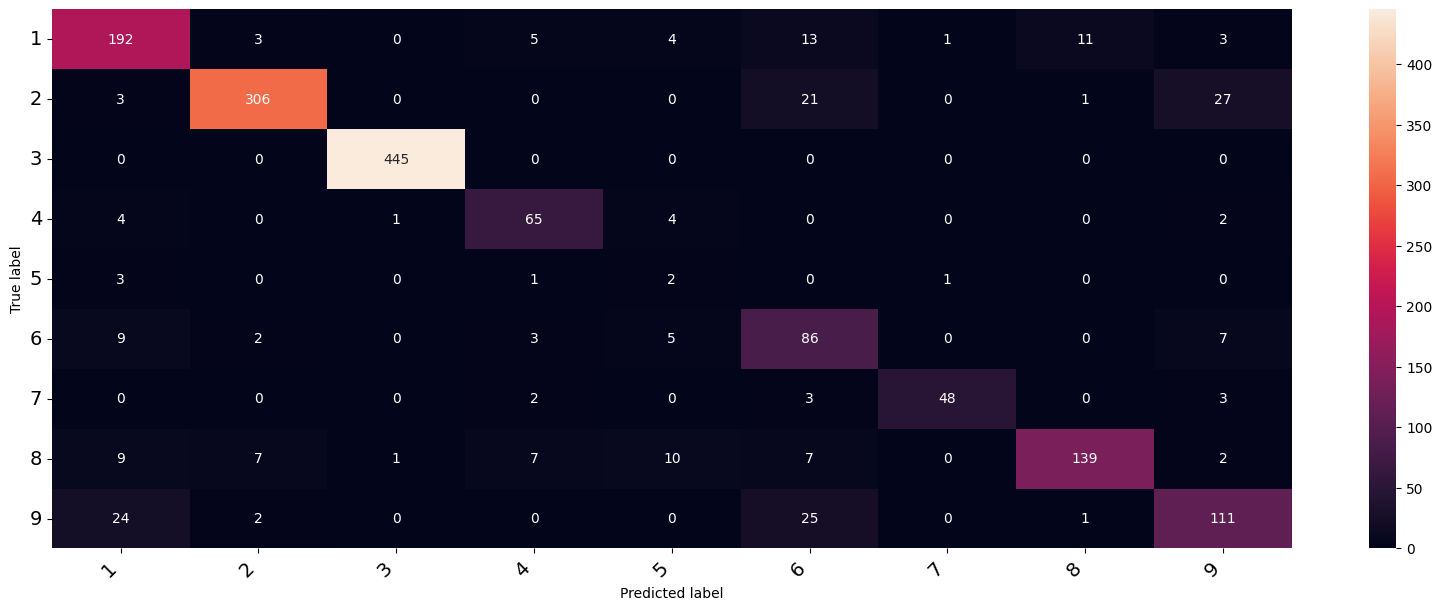

In [ ]:
import numpy as np
import pandas as pd

y_pred = np.argmax(Malware_model.predict(X_test), axis=-1)
y_pred

y_test2 = np.argmax(y_test, axis=1)


y_test2

from sklearn import metrics
c_matrix = metrics.confusion_matrix(y_test2, y_pred)

import seaborn as sns
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names= train_generator.class_indices.keys()
confusion_matrix(c_matrix, class_names, figsize = (20,7), fontsize=14)

results = pd.DataFrame({ 'CNN Model': 'Malware model',
    'Accuracy': [scores[1]],
    'Loss': [scores[0]],
    'Precision': [scores[3]],
    'Recall' : [scores[4]],
    'f1 score': [scores[2]]})

results

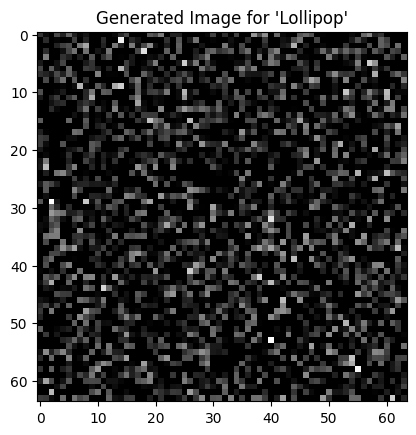

Fake image saved at '/content/drive/MyDrive/AI_SWU_PROJECT/test_image.png'


In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Lollipop 클래스에 해당하는 데이터셋 가져오기
lollipop_indices = np.where(y_train_new == 1)[0]
lollipop_images = X_train[lollipop_indices]

# 평균 이미지 생성
mean_lollipop_image = np.mean(lollipop_images, axis=0)

# 노이즈 추가
noise = np.random.normal(0, 0.05, mean_lollipop_image.shape)
fake_image = mean_lollipop_image + noise

# 값 클리핑 (0~1 범위 유지)
fake_image = np.clip(fake_image, 0, 1)

# 시각화
plt.imshow(fake_image.squeeze(), cmap='gray')
plt.title("Generated Image for 'Lollipop'")
plt.show()

# uint8 변환 및 저장
fake_image_uint8 = (fake_image * 255).astype(np.uint8)
img = Image.fromarray(fake_image_uint8.squeeze(), mode='L')

# 저장할 경로와 파일 이름 지정
save_path = "/content/drive/MyDrive/AI_SWU_PROJECT/test_image.png"  # Google Drive의 경로 예제
img.save(save_path)
print(f"Fake image saved at '{save_path}'")

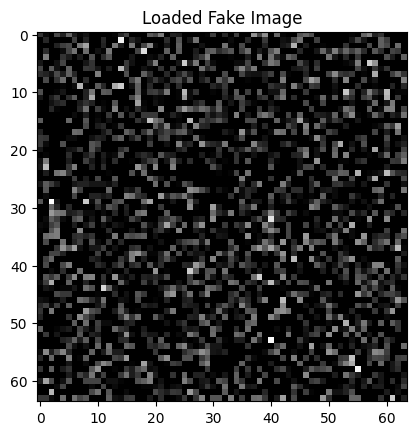

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 저장된 이미지 로드
test_path = "/content/drive/MyDrive/AI_SWU_PROJECT/test_image.png"  # 저장된 이미지 경로
test_image = Image.open(test_path)

# 시각화
plt.imshow(test_image, cmap='gray')
plt.title("Loaded Fake Image")
plt.show()

# 모델 입력에 맞게 전처리
loaded_image = np.array(test_image)  # PIL 이미지를 numpy 배열로 변환
loaded_image = loaded_image / 255.0   # 정규화 (0~1)
loaded_image = loaded_image.reshape(-1, 64, 64, 1)  # 모델 입력 형식에 맞게 변환

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
y_pred = np.argmax(Malware_model.predict(X_test), axis=-1)
print(classification_report(Y_test, y_pred))

import pickle
import matplotlib.pyplot as plt
from PIL import Image
import keras
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
import PIL

from keras.models import load_model

Malware_model.save('/content/drive/MyDrive/AI_SWU_PROJECT/my_model.h5')
model = load_model('/content/drive/MyDrive/AI_SWU_PROJECT/my_model.h5')

# img = load_img("/content/drive/MyDrive/AI_SWU_PROJECT classification/Malware_Classification/dataRaw/test.png")
# img = img.resize((64, 64))
# plt.imshow(img)
CATEGORIES = ['Ramnit','Lollipop', 'Kelihos_ver3', 'Vundo', 'Simda','Tracur', 'Kelihos_ver1','Obfuscator.ACY','Gatak']

# img = img_to_array(img)
# img = img.reshape( -1,64, 64,3)

#print(img)
# print(img.shape)

#model.summary()
prediction = model.predict(loaded_image)
pred_name = CATEGORIES[np.argmax(prediction)]
print(f"Predicted Class: {pred_name}")
print(f"Prediction Probabilities: {prediction}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


              precision    recall  f1-score   support

           0       0.79      0.83      0.81       232
           1       0.96      0.85      0.90       358
           2       1.00      1.00      1.00       445
           3       0.78      0.86      0.82        76
           4       0.08      0.29      0.12         7
           5       0.55      0.77      0.64       112
           6       0.96      0.86      0.91        56
           7       0.91      0.76      0.83       182
           8       0.72      0.68      0.70       163

    accuracy                           0.85      1631
   macro avg       0.75      0.77      0.75      1631
weighted avg       0.87      0.85      0.86      1631



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Predicted Class: Lollipop
Prediction Probabilities: [[5.6121852e-02 9.4387817e-01 0.0000000e+00 8.7178359e-15 0.0000000e+00
  4.5267902e-16 0.0000000e+00 2.0143974e-25 1.2829312e-19]]
